In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Building a MOC from a CDS/Vizier catalog

After a couple of conversations I had during the week of the 2nd ASTERICS VO school I've got two small TODO's hanging on my list, this is an answer to both. First one (to François) is an observation about CDS/Vizier LaMassa 2016 catalog's metadata; the second one (to Markus) is about MOC catalogs format. I will not get into the details -- since the respective discussion had already being done --, it is sufficient to say that:

1. some of Lamassa's null value are not properly read when using Astropy;
1. what I understand about a MOC catalog.

The data to be used is provided by Vizier, the [LaMassa et al, 2016, ApJ, 817, 172](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJ/817/172), in particular the ``ReadMe`` and ``chandra.dat`` files.
Software to handle the catalog will be [Astropy](http://www.astropython.org) and Thomas Boch's [mocpy](https://github.com/tboch/mocpy) and [Healpy](https://healpy.readthedocs.io/en/latest/).


TOC:
 * [Dealing with null values from Vizier metadata](#Dealing-with-null-values-from-Vizier-metadata)
 * [Generating a MOC catalog](#Generating-a-MOC-catalog)

In [2]:
baseurl = 'ftp://cdsarc.u-strasbg.fr/pub/cats/J/ApJ/817/172/'
readme_file = 'ReadMe'
chandra_file = 'chandra.dat'

import astropy
print "astropy version:",astropy.__version__

import mocpy
print "mocpy version:",mocpy.__version__

import healpy
print "healpy version:",healpy.__version__

astropy version: 1.2.1
mocpy version: 0.3.5
healpy version: 1.10.1


**Download ``ReadMe`` and ``chandra.dat`` files and save them inside ``./data/`` dir**

In [3]:
def download(path,filename,outdir):
    from urllib2 import urlopen
    url = path+filename
    f = urlopen(url)
    data = f.read()
    with open(outdir+filename, "wb") as fp:
        fp.write(data)

In [4]:
import os
if not os.path.isdir('data'):
    os.mkdir('data')
download(baseurl,readme_file,outdir='data/')
download(baseurl,chandra_file,outdir='data/')
!ls 'data/'

MOC_chandra.fits  ReadMe            chandra.dat
MOC_on_Aladin.png ReadMe_fix


## Dealing with null values from Vizier metadata

The goal here, as said before, is to show the "bug" in Vizier ReadMe (description) file when dealing with null values not properly formatted.

We start by opening the ``chandra`` table and noticing the values ``-999`` not being properly handled by Astropy as null values.

In [5]:
from astropy.table import Table
chandra = Table.read('data/chandra.dat',readme='data/ReadMe',format='ascii.cds')

In [6]:
chandra # Notice the '-999' values

MSID,ObsID,RAdeg,DEdeg,e_Pos,DistNN,InAO10,InAO13,RemLogNS,FSoft,B_FSoft,b_FSoft,CtSoft,FHard,B_FHard,b_FHard,CtHard,FFull,B_FFull,b_FFull,CtFull,logLSoft,logLHard,logLFull,RejS,SDSS,RASdeg,DESdeg,RelS,rS,CoaddS,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,SpecID,Class,zsp,r_zsp,WISE,RAWdeg,DEWdeg,e_RAWdeg,e_DEWdeg,RelW,rW,W1mag,e_W1mag,W1SNR,W2mag,e_W2mag,W2SNR,W3mag,e_W3mag,W3SNR,W4mag,e_W4mag,W4SNR,ExtW,RejW,UKIDSS,RAUdeg,DEUdeg,RelU,rU,Ymag,e_Ymag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,RejU,VHS,RAVdeg,DEVdeg,RelV,rV,JVmag,e_JVmag,HVmag,e_HVmag,KVmag,e_KVmag,RejV,GALEX,RAGdeg,DEGdeg,e_NUVPos,e_FUVPos,RelG,rG,NUV,e_NUV,FUV,e_FUV,FIRST,RAFdeg,DEFdeg,rF,F1.4GHz,e_F1.4GHz,RAHdeg,DEHdeg,rH,F250,e_F250,F350,e_F350,F500,e_F500,XMMAO10CP,XMMAO13CP,CPCoord
,,deg,deg,arcsec,arcsec,,,ct,1e-17 W / m2,1e-17 W / m2,1e-17 W / m2,ct,1e-17 W / m2,1e-17 W / m2,1e-17 W / m2,ct,1e-17 W / m2,1e-17 W / m2,1e-17 W / m2,ct,[10-7W],[10-7W],[10-7W],,,deg,deg,,arcsec,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,deg,deg,arcsec,arcsec,,arcsec,mag,mag,,mag,mag,,mag,mag,,mag,mag,,,,,deg,deg,,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,,,deg,deg,,arcsec,mag,mag,mag,mag,mag,mag,,,deg,deg,arcsec,arcsec,,arcsec,mag,mag,mag,mag,,deg,deg,arcsec,mJy,mJy,deg,deg,arcsec,mJy,mJy,mJy,mJy,mJy,mJy,,,
int64,int64,float64,float64,float64,float64,str9,str9,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,str19,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,str6,float64,int64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,str3,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str22,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str4,int64
15288,7750,29.212,-0.76,8.9,58.1,no,no,no,0.0,1.81,0.0,19.76,0.0,2.47,0.0,9.13,3.91,4.8,3.02,29.61,0.0,0.0,44.96,no,1237663783136460810,29.212,-0.759,0.93,2.6,no,19.1,0.02,19.12,0.01,19.06,0.01,18.75,0.01,18.76,0.03,453806688202418176,QSO,1.797,0,J015650.83-004532.7,29.21,-0.76,0.09,0.1,0.815,2.51,15.75,0.04,25.7,14.41,0.05,22.5,11.61,0.2,5.4,9.33,0.54,2.0,no,no,--,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,no,--,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,--,3779331664651486683,29.212,-0.759,0.53,0.59,0.9,3.39,20.55,0.04,21.32,0.07,--,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,--,--,0
15292,7750,29.32,-0.885,0.7,169.1,no,no,yes,0.0,0.37,0.0,6.34,0.0,3.4,0.0,18.85,2.11,2.54,1.68,24.69,0.0,0.0,43.14,no,1237657069549322337,29.321,-0.885,1.0,0.32,no,21.58,0.14,21.11,0.04,20.48,0.04,19.18,0.02,19.65,0.09,788134919485286400,QSO,0.422,0,--,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,no,no,433837789267,29.32,-0.885,0.997,0.31,19.03,0.08,18.43,0.08,17.62,0.07,16.63,0.05,no,472469107904,29.32,-0.885,0.998,0.26,18.32,0.03,17.58,0.03,16.89,0.04,--,--,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,--,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,--,--,0
15293,7750,29.356,-0.854,1.0,169.1,no,no,no,1.25,1.48,1.01,29.42,5.75,6.78,4.82,38.19,5.92,6.67,5.18,67.32,-999.0,-999.0,-999.0,no,1237657069549388227,29.356,-0.854,0.99,0.93,no,25.48,0.94,22.17,0.12,21.13,0.07,20.4,0.06,19.93,0.14,--,--,-999.0,--,J015725.41-005114.7,29.36,-0.85,0.07,0.07,0.997,1.05,15.03,0.03,33.8,13.91,0.04,26.9,11.09,0.12,8.8,8.18,0.22,4.9,

We can see records in columns ``logLSoft``, ``logLHard``, ``logLFull``, for example, showing the values ``-999.0``.
Although we already suspect, we go to ``ReadMe`` and double-check it to see what is there about Null values.
For those three example columns we see ``?=-999``, which is the right --although truncated/integer-- value.
For some reason, Astropy is not handling it as it should.

To fix this, we have sync the number of significat digits of the null values with the (declared) format.
For instance, those columns have a Format=``F7.2`` and so should the null values be declared as ``?=-999.00``.

Changing such signatures for those columns (``logLSoft``, ``logLHard`` and ``logLFull``) and saving them to file ``ReadMe_fix`` give us the following:

In [7]:
from astropy.table import Table
chandra = Table.read('data/chandra.dat',readme='data/ReadMe_fix',format='ascii.cds')
chandra

MSID,ObsID,RAdeg,DEdeg,e_Pos,DistNN,InAO10,InAO13,RemLogNS,FSoft,B_FSoft,b_FSoft,CtSoft,FHard,B_FHard,b_FHard,CtHard,FFull,B_FFull,b_FFull,CtFull,logLSoft,logLHard,logLFull,RejS,SDSS,RASdeg,DESdeg,RelS,rS,CoaddS,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,SpecID,Class,zsp,r_zsp,WISE,RAWdeg,DEWdeg,e_RAWdeg,e_DEWdeg,RelW,rW,W1mag,e_W1mag,W1SNR,W2mag,e_W2mag,W2SNR,W3mag,e_W3mag,W3SNR,W4mag,e_W4mag,W4SNR,ExtW,RejW,UKIDSS,RAUdeg,DEUdeg,RelU,rU,Ymag,e_Ymag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,RejU,VHS,RAVdeg,DEVdeg,RelV,rV,JVmag,e_JVmag,HVmag,e_HVmag,KVmag,e_KVmag,RejV,GALEX,RAGdeg,DEGdeg,e_NUVPos,e_FUVPos,RelG,rG,NUV,e_NUV,FUV,e_FUV,FIRST,RAFdeg,DEFdeg,rF,F1.4GHz,e_F1.4GHz,RAHdeg,DEHdeg,rH,F250,e_F250,F350,e_F350,F500,e_F500,XMMAO10CP,XMMAO13CP,CPCoord
,,deg,deg,arcsec,arcsec,,,ct,1e-17 W / m2,1e-17 W / m2,1e-17 W / m2,ct,1e-17 W / m2,1e-17 W / m2,1e-17 W / m2,ct,1e-17 W / m2,1e-17 W / m2,1e-17 W / m2,ct,[10-7W],[10-7W],[10-7W],,,deg,deg,,arcsec,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,deg,deg,arcsec,arcsec,,arcsec,mag,mag,,mag,mag,,mag,mag,,mag,mag,,,,,deg,deg,,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,,,deg,deg,,arcsec,mag,mag,mag,mag,mag,mag,,,deg,deg,arcsec,arcsec,,arcsec,mag,mag,mag,mag,,deg,deg,arcsec,mJy,mJy,deg,deg,arcsec,mJy,mJy,mJy,mJy,mJy,mJy,,,
int64,int64,float64,float64,float64,float64,str9,str9,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,str19,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,str6,float64,int64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,str3,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str22,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str4,int64
15288,7750,29.212,-0.76,8.9,58.1,no,no,no,0.0,1.81,0.0,19.76,0.0,2.47,0.0,9.13,3.91,4.8,3.02,29.61,0.0,0.0,44.96,no,1237663783136460810,29.212,-0.759,0.93,2.6,no,19.1,0.02,19.12,0.01,19.06,0.01,18.75,0.01,18.76,0.03,453806688202418176,QSO,1.797,0,J015650.83-004532.7,29.21,-0.76,0.09,0.1,0.815,2.51,15.75,0.04,25.7,14.41,0.05,22.5,11.61,0.2,5.4,9.33,0.54,2.0,no,no,--,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,no,--,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,--,3779331664651486683,29.212,-0.759,0.53,0.59,0.9,3.39,20.55,0.04,21.32,0.07,--,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,--,--,0
15292,7750,29.32,-0.885,0.7,169.1,no,no,yes,0.0,0.37,0.0,6.34,0.0,3.4,0.0,18.85,2.11,2.54,1.68,24.69,0.0,0.0,43.14,no,1237657069549322337,29.321,-0.885,1.0,0.32,no,21.58,0.14,21.11,0.04,20.48,0.04,19.18,0.02,19.65,0.09,788134919485286400,QSO,0.422,0,--,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,no,no,433837789267,29.32,-0.885,0.997,0.31,19.03,0.08,18.43,0.08,17.62,0.07,16.63,0.05,no,472469107904,29.32,-0.885,0.998,0.26,18.32,0.03,17.58,0.03,16.89,0.04,--,--,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,--,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,--,--,0
15293,7750,29.356,-0.854,1.0,169.1,no,no,no,1.25,1.48,1.01,29.42,5.75,6.78,4.82,38.19,5.92,6.67,5.18,67.32,--,--,--,no,1237657069549388227,29.356,-0.854,0.99,0.93,no,25.48,0.94,22.17,0.12,21.13,0.07,20.4,0.06,19.93,0.14,--,--,-999.0,--,J015725.41-005114.7,29.36,-0.85,0.07,0.07,0.997,1.05,15.03,0.03,33.8,13.91,0.04,26.9,11.09,0.12,8.8,8.18,0.22,4.9,no,no,433837

**That's it. After declaring the null values with all the significant numbers following the Format, such values are properly handled.**

## Generating a MOC catalog

Now we go through a MOC catalog creation. There is no problem here, just to answer Markus what I understand what a MOC is: a list of (unique) element numbers. The [section 2.3.1 NUNIQ packing of the IVOA MOC document version-1](http://ivoa.net/documents/MOC/) explains how the conversion between the two kinds of elements representation.

The lines below will use the catalog we just have in hands, ``chandra``, to build the MOC.
First, I will compute Healpix ``level/nside`` values based on the mean positional error of the catalog and then the MOC elements are computed from (RA,Dec) using HealPy.
MOCPy is used at the end to plot the MOC elements; Also Aladin is used to have a better view of the elements.
Files can be download from ``data/`` directory.

In [8]:
# A function to find out which healpix level corresponds a given (typical) size of coverage
def size2level(size):
    """
    Returns nearest Healpix level corresponding to a given diamond size
    
    The 'nearest' Healpix level is here to be the nearest greater level, 
    right before the first level smaller than 'size'.
    """
    # units
    from astropy import units as u

    # Structure to map healpix' levels to their angular sizes
    #
    healpix_levels = {
        0  : 58.63 * u.deg,
        1  : 29.32 * u.deg, 
        2  : 14.66 * u.deg, 
        3  : 7.329 * u.deg, 
        4  : 3.665 * u.deg, 
        5  : 1.832 * u.deg, 
        6  : 54.97 * u.arcmin, 
        7  : 27.48 * u.arcmin, 
        8  : 13.74 * u.arcmin, 
        9  : 6.871 * u.arcmin, 
        10 : 3.435 * u.arcmin, 
        11 : 1.718 * u.arcmin, 
        12 : 51.53 * u.arcsec, 
        13 : 25.77 * u.arcsec, 
        14 : 12.88 * u.arcsec, 
        15 : 6.442 * u.arcsec,
        16 : 3.221 * u.arcsec,
        17 : 1.61 * u.arcsec,
        18 : 805.2 * u.milliarcsecond,
        19 : 402.6 * u.milliarcsecond,
        20 : 201.3 * u.milliarcsecond,
        21 : 100.6 * u.milliarcsecond,
        22 : 50.32 * u.milliarcsecond,
        23 : 25.16 * u.milliarcsecond,
        24 : 12.58 * u.milliarcsecond,
        25 : 6.291 * u.milliarcsecond,
        26 : 3.145 * u.milliarcsecond,
        27 : 1.573 * u.milliarcsecond,
        28 : 786.3 * u.microarcsecond,
        29 : 393.2 * u.microarcsecond
    }
    
    assert size.unit
    ko = None
    for k,v in healpix_levels.iteritems():
        if v < 2 * size:  # extrapolating the error by one order of magnitude
            break
        ko = k
    return ko

import numpy as np
from astropy import units as u

median_positional_error = np.median(chandra['e_Pos']) * u.arcsec
level = size2level(median_positional_error)
nside = 2**level

print "Typical (median) position error: \n{}".format(median_positional_error)
print "\nCorrespondig healpix level: {} \n\t and nsize value: {}".format(level,nside)

Typical (median) position error: 
1.8 arcsec

Correspondig healpix level: 15 
	 and nsize value: 32768


In [9]:
def healpix_radec2pix(nside, ra, dec, nest=True):
    """
    convert ra,dec to healpix elements
    """
    def radec2thetaphi(ra,dec):
        """
        convert equatorial ra, dec in degrees
        to polar theta, phi in radians
        """
        def ra2phi(ra):
            import math
            return math.radians(ra)

        def dec2theta(dec):
            import math
            return math.pi/2 - math.radians(dec)

        _phi = ra2phi(ra)
        _theta = dec2theta(dec)
        return _theta,_phi
    
    import healpy

    _theta,_phi = radec2thetaphi(ra, dec)
    return healpy.ang2pix(nside, _theta, _phi, nest=nest)

In [10]:
radec = zip(chandra['RAdeg'],chandra['DEdeg'])
hpix = [ healpix_radec2pix(nside,ra,dec) for ra,dec in radec ]

**Here it is, the MOC catalog (the list of elements to be more precise):**

In [11]:
hpix

[4670494905,
 4670400279,
 4670403331,
 4670401645,
 4670392473,
 4670494759,
 4671384085,
 4671384357,
 4676978911,
 4671330533,
 4671331180,
 4989484038,
 4990210203,
 4990222218,
 4990210849,
 4990304600,
 4990212145,
 4990308017,
 4990309939,
 4989505731,
 4990308766,
 4989505904,
 4990314223,
 4990314200,
 4990315270,
 4990307128,
 4990219767,
 4990314273,
 4990313014,
 4989508090,
 4989591218,
 4989503515,
 4989602649,
 4989601755,
 4989603613,
 4989588848,
 4989600491,
 4989602599,
 4743815115,
 4743778943,
 4743778930,
 4743831719,
 4743798150,
 4743832559,
 4743796413,
 4743797180,
 4743807680,
 4743825454,
 4743807643,
 4743786078,
 4743807439,
 4743785967,
 4743786377,
 4743808188,
 4743810193,
 4743773411,
 4743810402,
 4743810473,
 4743812227,
 4743813175,
 4743810913,
 4743813811,
 4743771941,
 4743773703,
 4743773481,
 4743782977,
 4743773921,
 4743773667,
 4743773951,
 4743783386,
 4743784850,
 4743796117,
 4743785221,
 4743796519,
 4743798075,
 4743795509,
 4743786281,

**The plot made by MOCPy:**

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


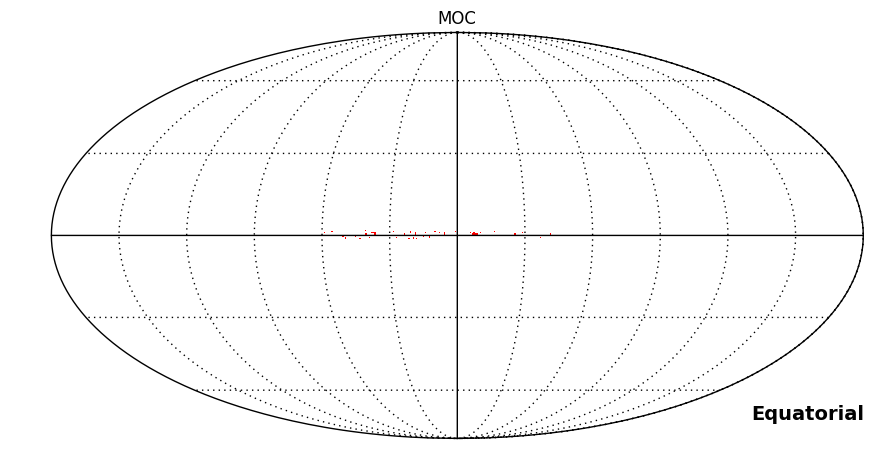

In [12]:
moc = mocpy.MOC()
moc.add_pix_list(level,hpix)
moc.plot()
moc.write('data/MOC_chandra.fits')

**And here after importing it to Aladin:**

In [13]:
from IPython.display import HTML
HTML('''
<figure>
  <img src="data/MOC_on_Aladin.png" alt="MOC printed on Aladin">
  <figcaption>Figure 1: MOC printed on Aladin</figcaption>
</figure>
''')